In [4]:
import os
import cv2
import imghdr
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn

# Reading, cleaning and processing data

### 1. Clean the dataset

Define the directory of the data and remove any images with different extensions than the ones specified

In [18]:
DATA_DIR = 'data'
IMG_EXT = ['png', 'jpg', 'jpeg', 'bmp']

In [19]:
def clean_images(data_dir : str, extensions : list):
    '''
        Looks for subfolders (which should be the classes to classify)
        of data_dir and removes the images which have 
        other extensions than the ones specified.
    '''
    for img_class in os.listdir(data_dir):                            # List every img class in data_dir
        for image in os.listdir(os.path.join(data_dir, img_class)):   # For every class, list the images
            image_path = os.path.join(data_dir, img_class, image)     # Get the path of the image
            try:
                img = cv2.imread(image_path)                          # Read the img with opencv - unnecessary?
                tip = imghdr.what(image_path)                         # Get the extension of the image
                if tip not in extensions:                             
                    os.remove(image_path)                             # Remove img if it has an unwanted extension
            except Exception as e:
                print(f'Issue with {image_path}')                     # Print a msg if there's an error with any img

In [36]:
clean_images(DATA_DIR, IMG_EXT)

### 2. Read and transform the data

The images must be resized to have the same resolution and must be a PyTorch tensor.

PyTorch has a really handy way of implementing these transformations through `torchvision.transforms`.

* `torchvision.transforms.Compose` creates a list of transformations that will be applied sequentially.
* `torchvision.transforms.Resize((255, 255))` resizes the data to the specified size.
* `torchvision.transforms.ToTensor()` converts the data into a torch.Tensor.

In [20]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((255, 255)),
                                            torchvision.transforms.ToTensor()])

Now through `torchvision.datasets.ImageFolder` read the directory of the data.

Note that the directory data must have subfolders like 'meme', 'family', 'dinner' that will be treated as
the classes for image classification.

Through the same method, the transformations can be applied by providing a value to the `transform` parameter.

In [63]:
data = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)

The classes and their corresponding label can be seen with `class_to_idx`. Remember that this is not an array or Tensor, just a container.

In [64]:
data.class_to_idx

{'family': 0, 'memes': 1}

The image samples can be accessed through `data.samples` and their respective labels with `data.targets`.

### 3. Create the data loaders

For better training, it is useful to separate the data in  multiple batches and shuffle the samples so that each batch has images from both classes.

A `DataLoader` in PyTorch isn't a list or a dataset that contains all the batches. Instead, it loads eatch sample (or batch) one at a time into memory. Basically, it can be treated as a generator.

Creating a `DataLoader` is easy. Use `torch.utils.data.DataLoader` and specify the dataset (in this case is the images loaded in `data`). At the same time, specify `batch_size` and `shuffle` so that PyTorch may automatically split the data and randomly shuffle it.

To get the next entry manually from `dataloader` one must call `next(iter(dataloader))`.


In [65]:
dataloader = torch.utils.data.DataLoader(dataset=data,   # The dataset
                                         batch_size=23,  # Each batch will have 23 elements
                                         shuffle=True)   # Shuffle the data

`batch_size` is 23 because there are 230 images for each class, therefore 460 samples in total. Just so that every batch has the same number of entries, I decided to use a number so that `batch_size % number` is 0. So, there will be 20 batches (460 / 23).

In [70]:
len(dataloader) # Number of batches

20

### 4. Split the data into train, test and validation sets

Select a manual seed just so that the results can be reproducible.

In [71]:
gen1 = torch.Generator().manual_seed(69) 

Really easy to split the data when using a `DataLoader`. Just use `torch.utils.data.random_split`, specify a loader, the percentage of the original data that each different set will represent and optionally a generator.

Note that `[0.7, 0.15, 0.15]` sums up to 1, then the first set will be 70% of `dataloader`, and the other two sets will split the remaining 30% of `dataloader` between them, so 15% each.

In [72]:
train_set, test_set, val_set = torch.utils.data.random_split(dataloader, [0.7, 0.15, 0.15], generator=gen1)

Remember there are 20 batches in this case. The sum of each set's length must add to 20.

In [74]:
print(len(train_set))
print(len(test_set))
print(len(val_set))

14
3
3


### 5. IMPORTANT NOTE ABOUT THE GENERATED SETS

Each set contains *BOTH* the data and the labels. So `train_set` contains the X_train and the y_train in *BATCHES*, the same applies for the test_set and val_set.

To access actual data, one must iterate through `set.dataset`. This is because `set.dataset` returns a DataLoader generator, but `set` has a type of Subset, which is not iterable nor indexable.

Also, when iterating `set.dataset` each element that it returns is a tuple in which the first element is the data and the second one are the labels for each sample in data for that batch. Just unwrap them like `x_batch, y_batch`.

In [78]:
type(train_set)

torch.utils.data.dataset.Subset

In [80]:
type(train_set.dataset)

torch.utils.data.dataloader.DataLoader

# The Deep Learning Model

### 1. The architecture

The model will consist of 3 convolutional blocks, 1 flatten layer and 2 fully connected linear layers.

In turn, each convolutional block is a sequential model containing:
* The convolutional layer.
* The activation layer, ReLU in this case.
* The pooling layer, MaxPooling2D in this case.

#### 1.1. The convolution blocks

*REMEMBER*: Each convolutional layer has a kernel of size 3x3. This means that each time the data goes through these layers it will come out with 2 pixel less because the kernel won't fit completely at the edges of the image. Then, 1 pixel is ignored on the left, right, the top and bottom.

##### 1.1.1 First convolutional block
-> input with shape `[23, 3, 255, 255]`.

Remember that the data will come with a size of `[23, 3, 255, 255]` since each batch has 23 elements, each image has 3 color channels (RGB) and a dimension of 256x256 (it shows 255 because the 0th element). Because of the 3 channels, the convolution layer will have 3 has the input channels.

After the convolution and activation, the data has a shape of `[23, 16, 253, 253]`, so each image has a res of 254x254 now.

The MaxPooling2D will halve the resolution to 127x127.

-> data output with shape of `[23, 16, 126, 126]`.

##### 1.1.2 Second convolutional block
-> input shape `[23, 16, 126, 126]`.

It has 16 channels as input since the first convolutional block has an output of 16 channels. It will output 32 channels.

After convolution & activation -> data with shape `[23, 32, 124, 124]`. Each img has res of 125x125.

For the pooling, halving the shape will result in `[23, 32, 62, 62]`.

-> output with shape `[23, 32, 62, 62]`

##### 1.1.3 Third convolutional block
-> input shape `[23, 32, 62, 62]`.

32 channels as input because seconds convolutional block outputs 32 channles. It will output 16 channels.

After convolution & activation -> data with shape of `[23, 32, 60, 60]`.

After pooling -> data with shape of `[23, 32, 30, 30]`

-> output with shape `[23, 16, 30, 30]`.

#### 1.2 The flatten layer
-> input with shape [23, 16, 30, 30].

When using `nn.Flatten(start_dim=1, end_dim=-1)` we are telling PyTorch to flatten the input array leaving the first dimension (index 0) the same but flattening all dimensions remaining. Remember that in Python the -1 means last element, in this case is the last dimension.

So, to know the shape of the output just multiply the length of each flattened dimension. In this case it would be 16 * 30 * 30 = 14400.

-> output with shape `[23, 14400]`.

#### 1.3 The dense blocks

##### 1.3.1 First dense block
-> input shape `[23, 14400]`.

The shape of `nn.Linear(23, 16 * 30 * 30)` is explained in the flatten layer.
Just apply the ReLU to the output of the linear layer.

-> output shape `[23, 10]`

##### 1.3.2 Second dense block
-> input shape `[23, 10]`

Input of 10 because the last dense block outputs 10 values.
Just apply the sigmoid activation function to the outputs of the linear layer.

-> output shape `[23, 1]`

#### 1.4 The output

Since the output has an extra dimension with a length of 1, just squeeze the tensor to remove this dimension.

This way, the output is just a 1D tensor that has the predicted class for each entry in the batch.

In [5]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv3_block = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.dense_block = nn.Sequential(
            nn.Linear(16 * 30 * 30, 10),
            nn.ReLU()
        )
        
        self.output = nn.Sequential(
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x : torch.Tensor):
        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.flatten(x)
        x = self.dense_block(x)
        return self.output(x).squeeze()
        

Instanciate the model

In [6]:
model = Model()

In [127]:
print(model)   # Useful way to see the architecture

Model(
  (conv1_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_block): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_block): Sequential(
    (0): Linear(in_features=14400, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


### 2. Tranining

To train the model we need an optimizer and a loss function.

In this case the ADAM optimizer will be used with the Binary Cross Entropy loss function (the log one).

In [129]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

Standard PyTorch training loop.

* Set the model's mode to training.
* Creates some variables to track useful values.
* Train the model for `epochs` epochs.
* Unwrap the `DataLoader` into the data batch and the y batch.
* Make the predictions and get the loss for each prediction.
* Perfom backpropagation.
* Step the optimizer.

Then test the model with the cross validation set.

* Unwrap the `DataLoader` into the data batch and the y batch.
* Make the predictions.
* Evaluate the predictions with the loss function.

After all that, just append the desired values to each list for later use.

In [147]:
def train_nn(epochs, 
             net : torch.nn.Module, 
             train_set : torch.utils.data.dataset.Subset,
             val_set : torch.utils.data.dataset.Subset) -> (torch.nn.Module, list, list, list):
    
    net.train()                                              # Set the NN to training mode.
    
    epoch_count, train_loss_vals, val_loss_vals = [], [], [] # List that will be used to check model performance
    
    for epoch in range(1, epochs+1):
        for x_batch, y_batch in train_set.dataset:           # Joint the corresponding batches and unwrap them
            y_batch = y_batch.type(torch.float32)
            y_pred = net(x_batch)                            # Make predictions for the current batch
            loss = loss_fn(y_pred, y_batch)                  # Compute the loss of the predictions
            optimizer.zero_grad()                            # Reset the gradients
            loss.backward()                                  # Perform the backpropagation
            optimizer.step()                                 # Optimize the model
            
        for data, labels in val_set.dataset:
            labels = labels.type(torch.float32)
            preds = net(data)
            val_loss = loss_fn(preds, labels)
    
        # if epoch % 10 == 0:
        epoch_count.append(epoch)                            
        train_loss_vals.append(loss)
        val_loss_vals.append(val_loss)
        print(f"Epoch {epoch}: Train loss of {loss}; Validation loss of {val_loss}")
        # print(net.state_dict())                            # Bad idea, the state_dict is huge
            
    return net, epoch_count, train_loss_vals, val_loss_vals

Now just train the model.

In [131]:
trained_model, epoch_l, train_loss_l, val_loss_l = train_nn(40, model, train_set, val_set)

Epoch 1: Train loss of 0.7435684204101562; Validation loss of 0.6014048457145691
Epoch 2: Train loss of 0.36416730284690857; Validation loss of 0.43258655071258545
Epoch 3: Train loss of 0.32709598541259766; Validation loss of 0.3609268367290497
Epoch 4: Train loss of 0.2838458716869354; Validation loss of 0.33327826857566833
Epoch 5: Train loss of 0.19682788848876953; Validation loss of 0.2861165404319763
Epoch 6: Train loss of 0.2786969542503357; Validation loss of 0.20031771063804626
Epoch 7: Train loss of 0.3550480604171753; Validation loss of 0.052339937537908554
Epoch 8: Train loss of 0.19568966329097748; Validation loss of 0.05785973742604256
Epoch 9: Train loss of 0.11430514603853226; Validation loss of 0.014042006805539131
Epoch 10: Train loss of 0.04119100794196129; Validation loss of 0.02495165541768074
Epoch 11: Train loss of 0.10354062914848328; Validation loss of 0.12072647362947464
Epoch 12: Train loss of 0.026145536452531815; Validation loss of 0.015372713096439838
Epoc

### 3. Plot the model loss funtion

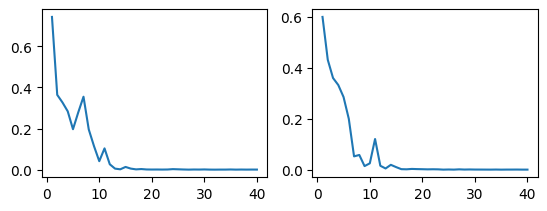

In [142]:
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
with torch.inference_mode():          # Deactivate gradient tracking
    ax1.plot(epoch_l, train_loss_l)      
    ax2.plot(epoch_l, val_loss_l)

### 4. Make predictions with the trained model on the test set

Simple testing method, that disables gradient tracking, unwraps the data and labels in test set Subset, makes the predictions and then evaluates the loss of the predictions and the actual labels.

In [152]:
def test_model(model : nn.Module, 
               test_set : torch.utils.data.dataset.Subset) -> None:
    model.eval()
    with torch.inference_mode():
        for test_data, test_label in test_set.dataset:
            test_pred = model(test_data)
            test_loss = loss_fn(test_pred, test_label.type(torch.float32))
            print(test_loss)
    model.train()

Now test the trained model

In [159]:
test_model(trained_model, test_set)

tensor(0.0002)
tensor(0.0002)
tensor(0.0001)
tensor(0.0003)
tensor(0.0005)
tensor(0.0002)
tensor(0.0003)
tensor(0.0004)
tensor(0.0003)
tensor(0.0002)
tensor(0.0004)
tensor(0.0001)
tensor(0.0003)
tensor(0.0002)
tensor(0.0002)
tensor(0.0004)
tensor(0.0002)
tensor(9.5598e-05)
tensor(0.0002)
tensor(0.0002)


# Saving and loading the model

Simple functions that save and load some model

In [7]:
def save_model(model : nn.Module, file_name : str) -> None:
    MODEL_DIR = Path('MODELS')
    MODEL_NAME = f'{file_name}.pth'
    MODEL_PATH = MODEL_DIR / MODEL_NAME
    
    torch.save(obj=trained_model.state_dict(),
               f=MODEL_PATH)

In [8]:
def load_state_d(file_name : str) -> Model:
    MODEL_DIR = Path('MODELS')
    MODEL_NAME = f'{file_name}.pth'
    MODEL_PATH = MODEL_DIR / MODEL_NAME
    
    state_d = torch.load(MODEL_PATH)
    m = Model()
    m.load_state_dict(state_d)
    return m

In [155]:
save_model(trained_model, 'trained_model_3')

In [9]:
loaded_model = load_state_d('trained_model_3')

Test the loaded model

In [158]:
test_model(loaded_model, test_set)

tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(6.8811e-05)
tensor(0.0007)
tensor(0.0003)
tensor(0.0001)
tensor(0.0005)
tensor(0.0002)
tensor(0.0001)
tensor(0.0002)
tensor(0.0001)
tensor(0.0002)
tensor(0.0003)
tensor(0.0001)
tensor(0.0003)
tensor(0.0006)
tensor(8.1278e-05)
tensor(0.0001)
tensor(0.0004)


# Test the model on real images

In [15]:
def process_img(file_name : str):
    TEST_IMGS = Path('TEST_IMGS')
    img = Image.open(TEST_IMGS / file_name)
    img_tensor = transform(img)
    return img_tensor[None, :]

In [16]:
def test_1_image(file_name : str):
    img_tensor = process_img(file_name)
    return loaded_model(img_tensor)

In [21]:
pred = test_1_image('nanny_test.jpg')
print(pred)

tensor(0.0002, grad_fn=<SqueezeBackward0>)


In [1]:
# pred2 = loaded_model(meme_test[:, :3, :, :])   # Dont select alpha form RGBA image

# Onnx & Onnx Runtine

In [13]:
import onnx
import onnxruntime

In [24]:
dummy_img = process_img('nanny_test.jpg')

In [56]:
input_names = ['input', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
output_names = ['output']

In [57]:
loaded_model.eval()
torch.onnx.export(loaded_model, 
                  dummy_img, 
                  "trained_model_3.onnx",
                  export_params=True,
                  do_constant_folding=True,
                  verbose=False,
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}},
                  input_names=input_names,
                  output_names=output_names)
                  # input_names=input_names, 
                  # output_names=output_names)

In [58]:
print(loaded_model)

Model(
  (conv1_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_block): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_block): Sequential(
    (0): Linear(in_features=14400, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [59]:
onnx_model = onnx.load("trained_model_3.onnx")

In [69]:
onnx.checker.check_model(onnx_model)

In [70]:
onx_session = onnxruntime.InferenceSession("trained_model_3.onnx")

In [73]:
# onx_session.run()

In [79]:
onx_input = {onx_session.get_inputs()[0].name: dummy_img.cpu().numpy()}

In [80]:
onx_out = onx_session.run(None, onx_input)

In [81]:
onx_out

[array(0.00020978, dtype=float32)]